<a href="https://colab.research.google.com/github/mdeniz1/datascienceprojects/blob/main/attribute_modelling_on_google_analytics_4_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install shap


In [ ]:
!pip install catboost

In [3]:
import pandas as pd
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
import joblib
import shap


In [4]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [ ]:
from google.cloud import bigquery

client = bigquery.Client(project='eng-wharf-410711')


df = client.query('''
  SELECT
  *
FROM `eng-wharf-410711.ga4.ga4_table`
limit 1500000
''').to_dataframe()


In [5]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [6]:
path = '/content/drive/My Drive/df_ga4_2.pkl'
df1=pd.read_pickle(path)

In [ ]:
#path = '/content/drive/My Drive/df_ga4_2.pkl'
#df.to_pickle(path)


In [7]:
df=df1.copy()

In [ ]:
df['event_bundle_sequence_id'].nunique()

1302127

In [ ]:
df['stream_id'].nunique()

1

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500000 entries, 0 to 1499999
Data columns (total 23 columns):
 #   Column                         Non-Null Count    Dtype  
---  ------                         --------------    -----  
 0   event_date                     1500000 non-null  object 
 1   event_timestamp                1500000 non-null  Int64  
 2   event_name                     1500000 non-null  object 
 3   event_params                   1500000 non-null  object 
 4   event_previous_timestamp       0 non-null        Int64  
 5   event_value_in_usd             1833 non-null     float64
 6   event_bundle_sequence_id       1500000 non-null  Int64  
 7   event_server_timestamp_offset  0 non-null        Int64  
 8   user_id                        0 non-null        object 
 9   user_pseudo_id                 1500000 non-null  object 
 10  privacy_info                   1500000 non-null  object 
 11  user_properties                1500000 non-null  object 
 12  user_first_tou

In [ ]:
# prompt: given df with event_timestamp and user_pseudo_id, show the rows with the user_pseudo_ids that have more than one unique event_timestamp

a=df.groupby('user_pseudo_id')['event_timestamp'].nunique().value_counts()


In [ ]:
df[df['user_pseudo_id']==25538783.8068965049]

,event_date,event_timestamp,event_name,event_params,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,user_pseudo_id,privacy_info,user_properties,user_first_touch_timestamp,user_ltv,device,geo,app_info,traffic_source,stream_id,platform,event_dimensions,ecommerce,items


as seen below, all the users have one session. so I can delete it

In [ ]:
df.head()

,event_date,event_timestamp,event_name,event_params,event_previous_timestamp,event_value_in_usd,event_bundle_sequence_id,event_server_timestamp_offset,user_id,user_pseudo_id,privacy_info,user_properties,user_first_touch_timestamp,user_ltv,device,geo,app_info,traffic_source,stream_id,platform,event_dimensions,ecommerce,items
0,20201110,1604971820344522,begin_checkout,"[{'key': 'clean_event', 'value': {'string_valu...",<NA>,NaN,1752648042,<NA>,None,21732519.8875634255,"{'analytics_storage': None, 'ads_storage': Non...",[],1604969882342411,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Africa', 'sub_continent': 'Nort...",None,"{'medium': 'referral', 'name': '(referral)', '...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
1,20210120,1611105762299838,page_view,"[{'key': 'page_location', 'value': {'string_va...",<NA>,NaN,3046368137,<NA>,None,8079006.6650182195,"{'analytics_storage': None, 'ads_storage': Non...",[],1610778647214866,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': '(none)', 'name': '(direct)', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
2,20210119,1611048922509453,view_item,"[{'key': 'page_title', 'value': {'string_value...",<NA>,NaN,-3130684596,<NA>,None,24467430.7181196119,"{'analytics_storage': None, 'ads_storage': Non...",[],1611048875682334,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'desktop', 'mobile_brand_name': '...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': '<Other>', 'name': '<Other>', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...","[{'item_id': 'GGOEGOCJ093999', 'item_name': 'G..."
3,20201212,1607757908307933,user_engagement,"[{'key': 'debug_mode', 'value': {'string_value...",<NA>,NaN,1763954426,<NA>,None,8135710.8287882373,"{'analytics_storage': None, 'ads_storage': Non...",[],1607757872095164,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'A...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': '(none)', 'name': '(direct)', 'sour...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]
4,20210125,1611551863121673,page_view,"[{'key': 'page_referrer', 'value': {'string_va...",<NA>,NaN,3622512011,<NA>,None,4258423.8896454000,"{'analytics_storage': None, 'ads_storage': Non...",[],1611551858110729,"{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'X...","{'continent': 'Americas', 'sub_continent': 'No...",None,"{'medium': 'organic', 'name': '(organic)', 'so...",2100450278,WEB,None,"{'total_item_quantity': None, 'purchase_revenu...",[]


In [ ]:
df.drop(['app_info', 'event_dimensions', 'event_server_timestamp_offset', 'user_id', 'event_previous_timestamp',
'event_timestamp', 'user_properties','user_first_touch_timestamp', 'stream_id','event_bundle_sequence_id'
], axis=1, inplace=True)

In [ ]:
df.head()

In [ ]:
df['event_timestamp'].nunique()


2259754

In [ ]:
df['user_pseudo_id'].nunique()


267915

In [ ]:
df['event_name'].value_counts()

page_view              943819
user_engagement        740393
scroll                 344465
view_item              269472
session_start          247928
first_visit            179802
view_promotion         131870
add_to_cart             40380
begin_checkout          27182
select_item             21384
view_search_results     18084
add_shipping_info       13884
add_payment_info         9732
select_promotion         6547
purchase                 3995
click                    1009
view_item_list             54
Name: event_name, dtype: int64

In [ ]:
df['event_date'] = pd.to_datetime(df['event_date'])

# Sort the DataFrame by 'event_date' and 'user_pseudo_id'
df = df.sort_values(['event_date', 'user_pseudo_id'])

# Convert 'event_date' column to datetime

# Group the DataFrame
grouped = df.groupby(['event_date', 'user_pseudo_id'])

# Filter out groups with less than 4 rows
filtered_groups = grouped.filter(lambda x: len(x) >= 4)
filtered_groups.reset_index(drop=True, inplace=True)

In [ ]:
# Create a new column 'n_engagements' and initialize it with 0
filtered_groups['n_engagements'] = 0

# Iterate over each group
for name, group in filtered_groups.groupby(['event_date', 'user_pseudo_id']):
    # Get the total number of members in the group
    group_size = len(group)

    # Iterate over each row in the group in reverse order
    for i, row in enumerate(group[::-1].itertuples(), start=1):
        # Calculate the value to be assigned to 'n_engagements'
        value = group_size - i+1

        # Assign the value to the corresponding row in the 'n_engagements' column
        filtered_groups.loc[row.Index, 'n_engagements'] = value

In [ ]:
filtered_groups.head(5)

,event_date,event_name,event_params,event_value_in_usd,user_pseudo_id,privacy_info,user_ltv,device,geo,traffic_source,platform,ecommerce,items,n_engagements
0,2020-11-01,user_engagement,"[{'key': 'source', 'value': {'string_value': '...",NaN,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[],1
1,2020-11-01,session_start,"[{'key': 'ga_session_number', 'value': {'strin...",NaN,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[],2
2,2020-11-01,user_engagement,"[{'key': 'debug_mode', 'value': {'string_value...",NaN,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[],3
3,2020-11-01,view_promotion,"[{'key': 'all_data', 'value': {'string_value':...",NaN,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[],4
4,2020-11-01,page_view,"[{'key': 'all_data', 'value': {'string_value':...",NaN,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[],5


In [ ]:
df_grouped=filtered_groups.copy()

In [ ]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147914 entries, 0 to 1147913
Data columns (total 14 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   event_date          1147914 non-null  datetime64[ns]
 1   event_name          1147914 non-null  object        
 2   event_params        1147914 non-null  object        
 3   event_value_in_usd  1831 non-null     float64       
 4   user_pseudo_id      1147914 non-null  object        
 5   privacy_info        1147914 non-null  object        
 6   user_ltv            1147914 non-null  object        
 7   device              1147914 non-null  object        
 8   geo                 1147914 non-null  object        
 9   traffic_source      1147914 non-null  object        
 10  platform            1147914 non-null  object        
 11  ecommerce           1147914 non-null  object        
 12  items               1147914 non-null  object        
 13  n_engagement

In [ ]:
df_grouped['event_value_in_usd'] = df_grouped['event_value_in_usd'].fillna(0)

In [ ]:
df_grouped.head()

,event_date,event_name,event_params,event_value_in_usd,event_bundle_sequence_id,user_pseudo_id,privacy_info,user_ltv,device,geo,traffic_source,platform,ecommerce,items
0,2020-11-01,user_engagement,"[{'key': 'source', 'value': {'string_value': '...",0.0,-2628586713,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[]
1,2020-11-01,session_start,"[{'key': 'ga_session_number', 'value': {'strin...",0.0,-1341154570,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[]
2,2020-11-01,user_engagement,"[{'key': 'debug_mode', 'value': {'string_value...",0.0,7038273736,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[]
3,2020-11-01,view_promotion,"[{'key': 'all_data', 'value': {'string_value':...",0.0,20088199,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[]
4,2020-11-01,page_view,"[{'key': 'all_data', 'value': {'string_value':...",0.0,-3423414439,1013442.5000387623,"{'analytics_storage': None, 'ads_storage': Non...","{'revenue': 0.0, 'currency': 'USD'}","{'category': 'mobile', 'mobile_brand_name': 'S...","{'continent': 'Americas', 'sub_continent': 'No...","{'medium': '(none)', 'name': '(direct)', 'sour...",WEB,"{'total_item_quantity': None, 'purchase_revenu...",[]


In [ ]:
#as seen below, platform variable has a constant value which means we can delete it
df_grouped['platform'].value_counts()

WEB    1147914
Name: platform, dtype: int64

In [ ]:
df_grouped.drop(['platform'], axis=1, inplace= True )

In [ ]:
df_grouped.drop(['items'], axis=1, inplace= True )

In [ ]:
df_grouped['medium'] = df['traffic_source'].apply(lambda x: x['medium'])
df_grouped['name'] = df['traffic_source'].apply(lambda x: x['name'])

# Delete the 'traffic_source' column
df_grouped = df_grouped.drop('traffic_source', axis=1)


In [ ]:
df_grouped['analytics_storage'] = df['privacy_info'].apply(lambda x: x['analytics_storage'])
df_grouped['ads_storage'] = df['privacy_info'].apply(lambda x: x['ads_storage'])

# Delete the 'traffic_source' column
df_grouped = df_grouped.drop('privacy_info', axis=1)


In [ ]:
print(df_grouped['analytics_storage'].value_counts())
print(df_grouped['ads_storage'].value_counts())

Series([], Name: analytics_storage, dtype: int64)
Series([], Name: ads_storage, dtype: int64)


In [ ]:
df_grouped = df_grouped.drop('analytics_storage', axis=1)
df_grouped = df_grouped.drop('ads_storage', axis=1)


In [ ]:
df_grouped['category'] = df['device'].apply(lambda x: x['category'])
df_grouped['mobile_brand_name'] = df['device'].apply(lambda x: x['mobile_brand_name'])

# Delete the 'traffic_source' column
df_grouped = df_grouped.drop('device', axis=1)


In [ ]:
df_grouped['revenue'] = df['user_ltv'].apply(lambda x: x['revenue'])
df_grouped['currency'] = df['user_ltv'].apply(lambda x: x['currency'])

# Delete the 'traffic_source' column
df_grouped = df_grouped.drop('user_ltv', axis=1)


In [ ]:
df_grouped['continent'] = df['geo'].apply(lambda x: x['continent'])
df_grouped['sub_continent'] = df['geo'].apply(lambda x: x['sub_continent'])

# Delete the 'traffic_source' column
df_grouped = df_grouped.drop('geo', axis=1)


In [ ]:
df_grouped['total_item_quantity'] = df['ecommerce'].apply(lambda x: x['total_item_quantity'])
df_grouped['purchase_revenue'] = df['ecommerce'].apply(lambda x: x['purchase_revenue'])

# Delete the 'traffic_source' column
df_grouped = df_grouped.drop('ecommerce', axis=1)


In [ ]:
#event_params also does not seem to reveal important information. so I delete it.
df_grouped = df_grouped.drop('event_params', axis=1)


In [ ]:
df_grouped = df_grouped.drop(['total_item_quantity', 'purchase_revenue'], axis=1)


In [ ]:
df_grouped.head(10)

,event_date,event_name,event_value_in_usd,user_pseudo_id,medium,name,category,mobile_brand_name,revenue,currency,continent,sub_continent,event_name_L1,event_name_L2,event_name_L3
0,2020-11-01,user_engagement,0.0,1013442.5000387623,referral,(referral),desktop,Google,0.0,USD,Africa,Northern Africa,NaN,NaN,NaN
1,2020-11-01,session_start,0.0,1013442.5000387623,(none),(direct),mobile,Samsung,0.0,USD,Americas,Northern America,user_engagement,NaN,NaN
2,2020-11-01,user_engagement,0.0,1013442.5000387623,<Other>,<Other>,desktop,Google,0.0,USD,Americas,Northern America,session_start,user_engagement,NaN
3,2020-11-01,view_promotion,0.0,1013442.5000387623,(none),(direct),mobile,Apple,0.0,USD,Americas,Northern America,user_engagement,session_start,user_engagement
4,2020-11-01,page_view,0.0,1013442.5000387623,organic,(organic),mobile,Xiaomi,0.0,USD,Americas,Northern America,view_promotion,user_engagement,session_start
5,2020-11-01,first_visit,0.0,1013442.5000387623,organic,(organic),desktop,Apple,0.0,USD,Europe,Northern Europe,page_view,view_promotion,user_engagement
6,2020-11-01,first_visit,0.0,1021793.7381839042,organic,(organic),desktop,Apple,0.0,USD,Americas,Northern America,NaN,NaN,NaN
7,2020-11-01,scroll,0.0,1021793.7381839042,(none),(direct),desktop,Google,0.0,USD,Asia,Southeast Asia,first_visit,NaN,NaN
8,2020-11-01,page_view,0.0,1021793.7381839042,<Other>,<Other>,desktop,Google,0.0,USD,Oceania,Australasia,scroll,first_visit,NaN
9,2020-11-01,page_view,0.0,1021793.7381839042,<Other>,<Other>,mobile,Samsung,0.0,USD,Africa,Northern Africa,page_view,scroll,first_visit


there are 144 row that are recorded as 'purchase'
but without any value in usd. I take this as an error in data preparation but keep these rows assuming the data labeler omitted filling event_value_in_usd column in 120 events.

In [ ]:
df1=df_grouped[df_grouped['event_value_in_usd']>0]
df1['event_name'].value_counts()

purchase    1831
Name: event_name, dtype: int64

as expected, if event value is greater than 0
it is a purchase. there is not any error in this case.

In [ ]:
positive=[]
for i in range(len(df_grouped)):
    if df_grouped['user_ltv'].iloc[i]['revenue']>0:
      positive.append(i)

In [ ]:
len(positive)

57609

In [ ]:
positive[0]

350

In [ ]:
df_grouped[df_grouped['user_pseudo_id']=='1494018.5183133777'].head()

In [ ]:
df_grouped['event_name_L1'] = df_grouped.groupby(['event_date', 'user_pseudo_id'])['event_name'].shift(1)
df_grouped['event_name_L2'] = df_grouped.groupby(['event_date', 'user_pseudo_id'])['event_name'].shift(2)
df_grouped['event_name_L3'] = df_grouped.groupby(['event_date', 'user_pseudo_id'])['event_name'].shift(3)


In [ ]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1147914 entries, 0 to 1147913
Data columns (total 16 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   event_date          1147914 non-null  datetime64[ns]
 1   event_name          1147914 non-null  object        
 2   event_value_in_usd  1147914 non-null  float64       
 3   user_pseudo_id      1147914 non-null  object        
 4   n_engagements       1147914 non-null  int64         
 5   medium              1147914 non-null  object        
 6   name                1147914 non-null  object        
 7   category            1147914 non-null  object        
 8   mobile_brand_name   1147914 non-null  object        
 9   revenue             1147914 non-null  float64       
 10  currency            1147914 non-null  object        
 11  continent           1147914 non-null  object        
 12  sub_continent       1147914 non-null  object        
 13  event_name_L

In [ ]:
df_grouped.dropna(inplace=True)


In [ ]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865683 entries, 3 to 1147913
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   event_date          865683 non-null  datetime64[ns]
 1   event_name          865683 non-null  object        
 2   event_value_in_usd  865683 non-null  float64       
 3   user_pseudo_id      865683 non-null  object        
 4   n_engagements       865683 non-null  int64         
 5   medium              865683 non-null  object        
 6   name                865683 non-null  object        
 7   category            865683 non-null  object        
 8   mobile_brand_name   865683 non-null  object        
 9   revenue             865683 non-null  float64       
 10  currency            865683 non-null  object        
 11  continent           865683 non-null  object        
 12  sub_continent       865683 non-null  object        
 13  event_name_L1       865683 n

In [ ]:
df_grouped.head(100)

In [ ]:
df_grouped['currency'].value_counts()

USD    865683
Name: currency, dtype: int64

In [ ]:
df_grouped.drop(['currency'], axis=1, inplace= True )

now we can also delete event_date, user_pseudo_id columns and event_value_in_usd

In [ ]:
df_grouped.drop(['user_pseudo_id', 'event_value_in_usd','event_date','revenue'], axis=1, inplace= True )

In [ ]:
df_grouped['user_pseudo_id'].nunique()

79929

In [ ]:
df_grouped.head()

,event_date,event_name,n_engagements,medium,name,category,mobile_brand_name,revenue,continent,sub_continent,event_name_L1,event_name_L2,event_name_L3,purchase
3,2020-11-01,view_promotion,4,(none),(direct),mobile,Apple,0.0,Americas,Northern America,user_engagement,session_start,user_engagement,0
4,2020-11-01,page_view,5,organic,(organic),mobile,Xiaomi,0.0,Americas,Northern America,view_promotion,user_engagement,session_start,0
5,2020-11-01,first_visit,6,organic,(organic),desktop,Apple,0.0,Europe,Northern Europe,page_view,view_promotion,user_engagement,0
9,2020-11-01,page_view,4,<Other>,<Other>,mobile,Samsung,0.0,Africa,Northern Africa,page_view,scroll,first_visit,0
10,2020-11-01,user_engagement,5,(data deleted),(data deleted),mobile,Apple,0.0,Asia,Southeast Asia,page_view,page_view,scroll,0


event name is the target column. There are 17 different events and the desired outcome is the purchase event. So I choose purchase as the target and label it as 1 and leave others as 0.

In [ ]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865683 entries, 3 to 1147913
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   event_date         865683 non-null  datetime64[ns]
 1   event_name         865683 non-null  object        
 2   n_engagements      865683 non-null  int64         
 3   medium             865683 non-null  object        
 4   name               865683 non-null  object        
 5   category           865683 non-null  object        
 6   mobile_brand_name  865683 non-null  object        
 7   revenue            865683 non-null  float64       
 8   continent          865683 non-null  object        
 9   sub_continent      865683 non-null  object        
 10  event_name_L1      865683 non-null  object        
 11  event_name_L2      865683 non-null  object        
 12  event_name_L3      865683 non-null  object        
 13  purchase           865683 non-null  int64  

In [ ]:
# prompt: out of event_name columns, create a new colum with the name 'purchase' and write 1 if the event is 'purchase' otherwise 0

df_grouped['purchase'] = df_grouped['event_name'].apply(lambda x: 1 if x=='purchase' else 0)
df_grouped.drop('event_name', axis=1, inplace=True)

In [ ]:
df_grouped.head()

,event_date,event_name,n_engagements,medium,name,category,mobile_brand_name,revenue,continent,sub_continent,event_name_L1,event_name_L2,event_name_L3,purchase
3,2020-11-01,view_promotion,4,(none),(direct),mobile,Apple,0.0,Americas,Northern America,user_engagement,session_start,user_engagement,0
4,2020-11-01,page_view,5,organic,(organic),mobile,Xiaomi,0.0,Americas,Northern America,view_promotion,user_engagement,session_start,0
5,2020-11-01,first_visit,6,organic,(organic),desktop,Apple,0.0,Europe,Northern Europe,page_view,view_promotion,user_engagement,0
9,2020-11-01,page_view,4,<Other>,<Other>,mobile,Samsung,0.0,Africa,Northern Africa,page_view,scroll,first_visit,0
10,2020-11-01,user_engagement,5,(data deleted),(data deleted),mobile,Apple,0.0,Asia,Southeast Asia,page_view,page_view,scroll,0


In [ ]:
df_grouped.head()

,medium,name,category,mobile_brand_name,revenue,continent,sub_continent,event_name_L1,event_name_L2,event_name_L3,purchase
3,(none),(direct),mobile,Apple,0.0,Americas,Northern America,user_engagement,session_start,user_engagement,0
4,organic,(organic),mobile,Xiaomi,0.0,Americas,Northern America,view_promotion,user_engagement,session_start,0
5,organic,(organic),desktop,Apple,0.0,Europe,Northern Europe,page_view,view_promotion,user_engagement,0
9,<Other>,<Other>,mobile,Samsung,0.0,Africa,Northern Africa,page_view,scroll,first_visit,0
10,(data deleted),(data deleted),mobile,Apple,0.0,Asia,Southeast Asia,page_view,page_view,scroll,0


In [ ]:
path = '/content/drive/My Drive/df_grouped_ga4.pkl'
df_grouped.to_pickle(path)


In [8]:
path = '/content/drive/My Drive/df_grouped_ga4.pkl'
df_grouped=pd.read_pickle(path)

Predicting Model Building with Catboost

firstly, test-train split

In [ ]:
df_grouped.head()

,n_engagements,medium,name,category,mobile_brand_name,continent,sub_continent,event_name_L1,event_name_L2,event_name_L3,purchase
3,4,(none),(direct),mobile,Apple,Americas,Northern America,user_engagement,session_start,user_engagement,0
4,5,organic,(organic),mobile,Xiaomi,Americas,Northern America,view_promotion,user_engagement,session_start,0
5,6,organic,(organic),desktop,Apple,Europe,Northern Europe,page_view,view_promotion,user_engagement,0
9,4,<Other>,<Other>,mobile,Samsung,Africa,Northern Africa,page_view,scroll,first_visit,0
10,5,(data deleted),(data deleted),mobile,Apple,Asia,Southeast Asia,page_view,page_view,scroll,0


In [9]:
df_grouped=df_grouped.astype('category')
df_grouped['n_engagements']=df_grouped['n_engagements'].astype('int')

In [ ]:
df_grouped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 865683 entries, 3 to 1147913
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   n_engagements      865683 non-null  int64   
 1   medium             865683 non-null  category
 2   name               865683 non-null  category
 3   category           865683 non-null  category
 4   mobile_brand_name  865683 non-null  category
 5   continent          865683 non-null  category
 6   sub_continent      865683 non-null  category
 7   event_name_L1      865683 non-null  category
 8   event_name_L2      865683 non-null  category
 9   event_name_L3      865683 non-null  category
 10  purchase           865683 non-null  category
dtypes: category(10), int64(1)
memory usage: 21.5 MB


In [10]:
X = df_grouped.drop('purchase', axis=1)
y = df_grouped['purchase']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

In [11]:
categorical_features = ['name', 'category', 'mobile_brand_name', 'continent', 'sub_continent',
                        'event_name_L1', 'event_name_L2', 'event_name_L3', 'medium']


In [ ]:

params = {
    'iterations': [ 500, 600],
    'depth': [ 8, 10,12],
    'learning_rate': [ 0.05,0.01],
    'l2_leaf_reg': [1, 3, 5],
    'auto_class_weights': ['Balanced']

}

cv = StratifiedKFold(n_splits=2)

clf = CatBoostClassifier(cat_features=categorical_features, task_type='GPU')
search1 = RandomizedSearchCV(clf, param_distributions=params, n_iter=8, cv=cv, scoring='recall')
search1.fit(X_train, y_train)

In [ ]:

best_estimator = search1.best_estimator_

# Training set
y_train_pred = best_estimator.predict(X_train)
train_recall_score = recall_score(y_train, y_train_pred)

# Cross-validation
cv_result = search1.best_score_

# Test set
y_pred = best_estimator.predict(X_test)
test_recall_score = recall_score(y_test, y_pred)

print(f"Train F1 Score: {train_recall_score:.2f}")
print(f"Mean CV F1 Score: {cv_result:.2f}")
print(f"Test F1 Score: {test_recall_score:.2f}")

print("Best Parameters:", search1.best_params_)

Train F1 Score: 0.78
Mean CV F1 Score: 0.21
Test F1 Score: 0.46
Best Parameters: {'learning_rate': 0.01, 'l2_leaf_reg': 5, 'iterations': 600, 'depth': 8, 'auto_class_weights': 'Balanced'}


In [ ]:

params = {
    'iterations': [ 600,700],
    'depth': [ 8, 6],
    'learning_rate': [0.01, 0.005],
    'l2_leaf_reg': [ 5,6],
    'auto_class_weights': ['Balanced']

}

cv = StratifiedKFold(n_splits=2)

clf = CatBoostClassifier(cat_features=categorical_features, task_type='GPU')
search2 = RandomizedSearchCV(clf, param_distributions=params, n_iter=8, cv=cv, scoring='recall')
search2.fit(X_train, y_train)

In [16]:

best_estimator = search2.best_estimator_

# Training set
y_train_pred = best_estimator.predict(X_train)
train_recall_score = recall_score(y_train, y_train_pred)

# Cross-validation
cv_result = search2.best_score_

# Test set
y_pred = best_estimator.predict(X_test)
test_recall_score = recall_score(y_test, y_pred)

print(f"Train F1 Score: {train_recall_score:.2f}")
print(f"Mean CV F1 Score: {cv_result:.2f}")
print(f"Test F1 Score: {test_recall_score:.2f}")

print("Best Parameters:", search2.best_params_)

Train F1 Score: 0.75
Mean CV F1 Score: 0.64
Test F1 Score: 0.69
Best Parameters: {'learning_rate': 0.005, 'l2_leaf_reg': 6, 'iterations': 600, 'depth': 6, 'auto_class_weights': 'Balanced'}


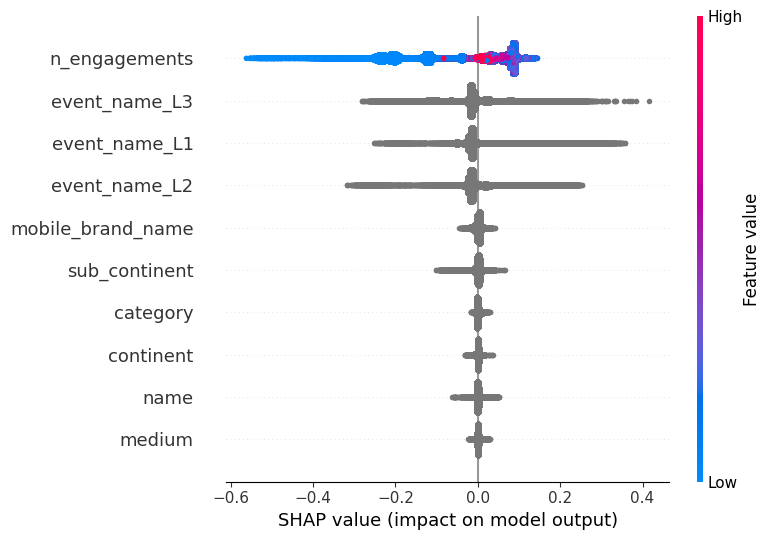

In [21]:
explainer = shap.Explainer(best_estimator)
shap_values = explainer(X_train)
shap.summary_plot(shap_values, X_train)


